
# DSE511 — Homework #4: Sorting, Data Structures, and Big‑O

**Instructor:** Scott Emrich  
**Course:** DSE 511 – Fall 2025  
**Starter Notebook Generated:** 2025-09-10 16:29:27

---

## How to use this notebook
- Run each cell in order. Fill in any **TODO** sections.
- Keep your code **well‑commented** and your plots clearly labeled.
- For reproducibility, set the random seed as shown below.
- When you're done, export both the `.ipynb` and an `.html` of this notebook and submit on Canvas.

> **Reminder:** When making charts, use **matplotlib**, give each chart its **own figure** (no subplots), and **do not set explicit colors** unless instructed.


## Setup

In [1]:
!pip install matplotlib

# Reproducibility
import numpy as np #Imports NumPy
import random #Imports Python's built-in random module
rng = np.random.default_rng(seed=511) #Sets the random seed so any random numbers generated will be reproducible
random.seed(511)

# Timing and plotting
import time #used to measure execution time
import matplotlib.pyplot as plt #plotting library for graphs and figures

# Utility: timing helper. This helps measure how long a function takes to run
def time_function(fn, *args, repeat=5, **kwargs): 
    """Return the best of `repeat` wall-clock timings for fn(*args, **kwargs)."""
    best = float('inf')
    result = None
    for _ in range(repeat):
        start = time.perf_counter()
        out = fn(*args, **kwargs)
        elapsed = time.perf_counter() - start
        if elapsed < best:
            best = elapsed
            result = out
    return best, result

print("Environment ready.")


Environment ready.



---
## Part A — Sorting Showdown

**Goal:** Empirically compare sorting algorithms and relate runtime to big‑O.

You will:
1. Generate integer arrays of increasing size.
2. Sort using:
   - Python built‑in `sorted()` (Time to sort ~ O(n log n) average/worst on random data)
   - Your own **insertion sort** (O(n²))
   - One additional algorithm of your choice (e.g., `numpy.sort`); must add
3. Measure wall‑clock runtimes as `n` grows.
4. Plot runtime vs `n` and discuss alignment with theory.


In [2]:
#Implement insertion sort (I used this website to help me https://www.geeksforgeeks.org/python/python-program-for-insertion-sort/)
def insertionSort(arr):
    a = list(arr)  # copy input
    n = len(a)
    if n <= 1:
        return a
    for i in range(1, n):
        key = a[i]
        j = i - 1
        while j >= 0 and key < a[j]:
            a[j+1] = a[j]
            j -= 1
        a[j+1] = key
    return a  # return sorted copy

# Sanity check
sample = [5, 2, 4, 6, 1, 3]
assert insertionSort(sample) == sorted(sample)
print("Insertion sort sanity check passed.")


Insertion sort sanity check passed.


In [3]:
#Generate integer arrays of different sizes
# Experiment sizes (adjust if runtime too long or too short); you can also add more data points
sizes = [10**3, 10**4, 10**5, 10**6] 
repeat = 3

# Cap insertion sort at manageable n
ins_cap = 20_000


In [7]:
#I'm interested in quicksort, since it's considered one of the best
#I obtained the code from https://www.geeksforgeeks.org/dsa/python-program-for-quicksort/
def quicksort_inplace(arr):
    a = list(arr)  # copy so original is not modified

    def partition(array, low, high):
        pivot = array[high]
        i = low - 1
        for j in range(low, high):
            if array[j] <= pivot:
                i += 1
                array[i], array[j] = array[j], array[i]
        array[i + 1], array[high] = array[high], array[i + 1]
        return i + 1

    def quickSort(array, low, high):
        if low < high:
            pi = partition(array, low, high)
            quickSort(array, low, pi - 1)
            quickSort(array, pi + 1, high)

    quickSort(a, 0, len(a) - 1)
    return a

    
results = {
    'n': [],
    'sorted_builtin': [],
    'insertion_sort': [],
    'quicksort': [] 
}

#Code for numpy_sort
for n in sizes:
    # Generate random array
    data = rng.integers(low=0, high=10_000_000, size=n, dtype=np.int64)
    
    # Time Python built-in sorted()
    t_sorted, _ = time_function(sorted, data, repeat=repeat)
    
    # Time insertion sort (only if n <= ins_cap)
    if n <= ins_cap:
        t_insert, _ = time_function(insertionSort, data, repeat=repeat)
    else:
        t_insert = np.nan

    # Time NumPy sort
    t_numpy, _ = time_function(np.sort, data, repeat=repeat)
    
    # Append results
    results['n'].append(n)
    results['sorted_builtin'].append(t_sorted)
    results['insertion_sort'].append(t_insert)
    results['quicksort'].append(t_numpy)

import pandas as pd
dfA = pd.DataFrame(results)
dfA


,n,sorted_builtin,insertion_sort,quicksort
0,1000,0.000218,0.019322,0.000020
1,10000,0.002385,2.133034,0.000076
2,100000,0.023173,NaN,0.001002
3,1000000,0.433118,NaN,0.013519


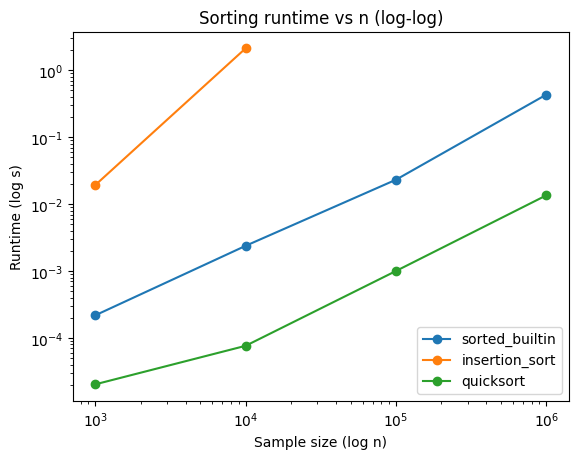

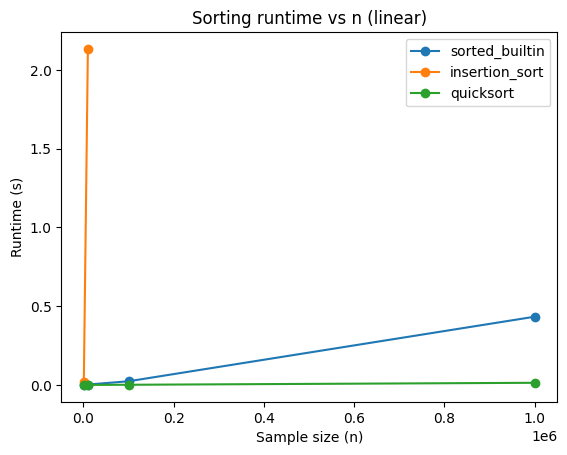

In [9]:
#plot linear plot from results using the log log template to help.  Need two plots for full credit

#plot on log-log scale
plt.figure()
for key in ['sorted_builtin', 'insertion_sort', 'quicksort']:
    plt.plot(dfA['n'], dfA[key], marker='o', label=key)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sample size (log n)')
plt.ylabel('Runtime (log s)')
plt.title('Sorting runtime vs n (log-log)')
plt.legend()
plt.show()

#linear plot
plt.figure()
for key in ['sorted_builtin', 'insertion_sort', 'quicksort']:
    plt.plot(dfA['n'], dfA[key], marker='o', label=key)
plt.xlabel('Sample size (n)')
plt.ylabel('Runtime (s)')
plt.title('Sorting runtime vs n (linear)')
plt.legend()
plt.show()


---
## Part B — Data Structures in Action: Membership Testing

**Goal:** Compare membership query performance for `list` (≈ O(n)), `set` (≈ O(1) average), and `dict` (≈ O(1) average).

You will:
1. Build collections of increasing size of unique IDs/strings.
2. Generate random queries that are both present and absent.
3. Measure membership test times (`x in structure`) for each structure type.
4. Plot how query time scales with `n`.


In [7]:

sizes_B = [10_000, 100_000, 500_000]
queries_per_size = 1_000

def gen_ids(n):
    ids = [f"id_{i:07d}" for i in range(n)]
    rng.shuffle(ids)
    return ids

def membership_timing(ids, structure_type='list'):
    if structure_type == 'list':
        coll = list(ids)
        def contains(x): return x in coll
    elif structure_type == 'set':
        coll = set(ids)
        def contains(x): return x in coll
    elif structure_type == 'dict':
        coll = {x: True for x in ids}
        def contains(x): return x in coll
    
    present = rng.choice(ids, size=queries_per_size//2, replace=False)
    absent = [f"nope_{i:07d}" for i in range(queries_per_size - len(present))]
    queries = np.concatenate([present, absent])
    rng.shuffle(queries)
    
    start = time.perf_counter()
    for q in queries:
        _ = contains(q)
    elapsed = time.perf_counter() - start
    return elapsed

records = {'n': [], 'structure': [], 'time_s': []}

for n in sizes_B:
    ids = gen_ids(n)
    for stype in ['list', 'set', 'dict']:
        t = membership_timing(ids, structure_type=stype)
        records['n'].append(n)
        records['structure'].append(stype)
        records['time_s'].append(t)

dfB = pd.DataFrame(records)
dfB


,n,structure,time_s
0,10000,list,0.114504
1,10000,set,0.000285
2,10000,dict,0.000215
3,100000,list,0.947654
4,100000,set,0.000403
5,100000,dict,0.000473
6,500000,list,18.191219
7,500000,set,0.000457
8,500000,dict,0.000686


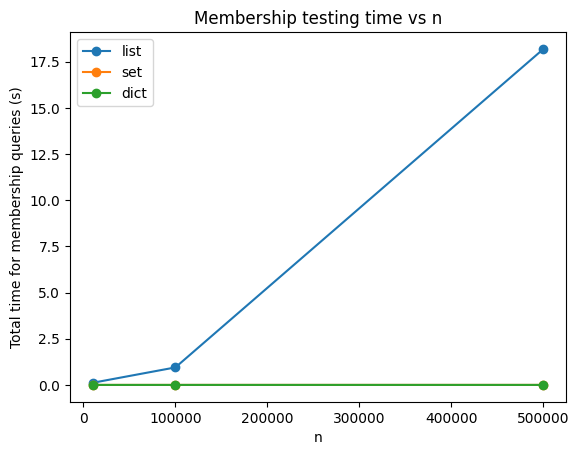

In [8]:

plt.figure()
for stype in ['list', 'set', 'dict']:
    sub = dfB[dfB['structure'] == stype]
    plt.plot(sub['n'], sub['time_s'], marker='o', label=stype)
plt.xlabel('n')
plt.ylabel('Total time for membership queries (s)')
plt.title('Membership testing time vs n')
plt.legend()
plt.show()



---
## Part C — Reflection

In 1–2 pages, discuss:
- How well did your empirical results align with expected big‑O?
- What practical advice would you give a teammate choosing data structures and sorting methods?
- Were there any surprises in your experiments? Explain.
- How did you ensure reproducibility?
